In [48]:
import pandas as pd
import numpy as np

import torch
from torch.utils.data import DataLoader
from scipy.special import softmax

import librosa
import librosa.display
import matplotlib.pyplot as plt
from pathlib import Path
from tqdm import tqdm

from omegaconf import OmegaConf

from soundbay.utils.checkpoint_utils import merge_with_checkpoint
from soundbay.conf_dict import models_dict
from soundbay.data import InferenceDataset
from soundbay.conf_dict import models_dict, datasets_dict
# from soundbay.models import load_model

In [ ]:
def load_model(model_params, checkpoint_state_dict):
    """
    load_model receives model params and state dict, instantiating a model and loading trained parameters.
    Input:
        model_params: config arguments of model object
        checkpoint_state_dict: dict including the train parameters to be loaded to the model
    Output:
        model: nn.Module object of the model
    """

    model_params = OmegaConf.to_container(model_params) 
    model = models_dict[model_params.pop('_target_')](**model_params)
    model.load_state_dict(checkpoint_state_dict)
    return model

In [ ]:
# set device
if not torch.cuda.is_available():
    device = torch.device("cpu")
else:
    device = torch.device("cuda")

In [ ]:
# load checkpoint:
# checkpoint_path = Path('/mnt/d/DeepVoice/checkpoints/ResNet1Channel_spec_1000__4_sec/best.pth')
# args = OmegaConf.load('/mnt/d/DeepVoice/checkpoints/ResNet1Channel_spec_1000__4_sec/args.yaml')

checkpoint_path = Path('/mnt/d/DeepVoice/checkpoints/CNNRNN_4_sec_multi_label/best.pth')
args = OmegaConf.load('/mnt/d/DeepVoice/checkpoints/CNNRNN_4_sec_multi_label/args.yaml')

ckpt_dict = torch.load(checkpoint_path, map_location=torch.device('cpu'), weights_only=False)
ckpt_args = ckpt_dict['args']
ckpt = ckpt_dict['model']

default_norm_func = 'softmax' if args.data.label_type == 'single_label' else 'sigmoid'

In [ ]:
batch_size = args.data.batch_size
# dataset_args = args.data.test_dataset
model_args = args.model.model
label_names = args.data.label_names

In [ ]:
# load model
model = load_model(model_args, ckpt).to(device)

In [ ]:
# load dataset args:
dataset_args = OmegaConf.load('./soundbay/conf/data/fannie_file_test.yaml')

args = merge_with_checkpoint(dataset_args, ckpt_args)
dataset_args = args.data.test_dataset
dataset_args.data_sample_rate = args.data.data_sample_rate
dataset_args.sample_rate = args.data.sample_rate

dataset_args = dict(dataset_args)

# I want to have prediction every 1 second
dataset_args['overlap'] = 1 - 1 / 7  # 1 second

dataset_type = dataset_args.pop('_target_')

test_dataset = datasets_dict[dataset_type](**dataset_args)
test_dataset = DataLoader(test_dataset, batch_size=batch_size, shuffle=False, num_workers=0)

In [ ]:
args.data
dataset_args

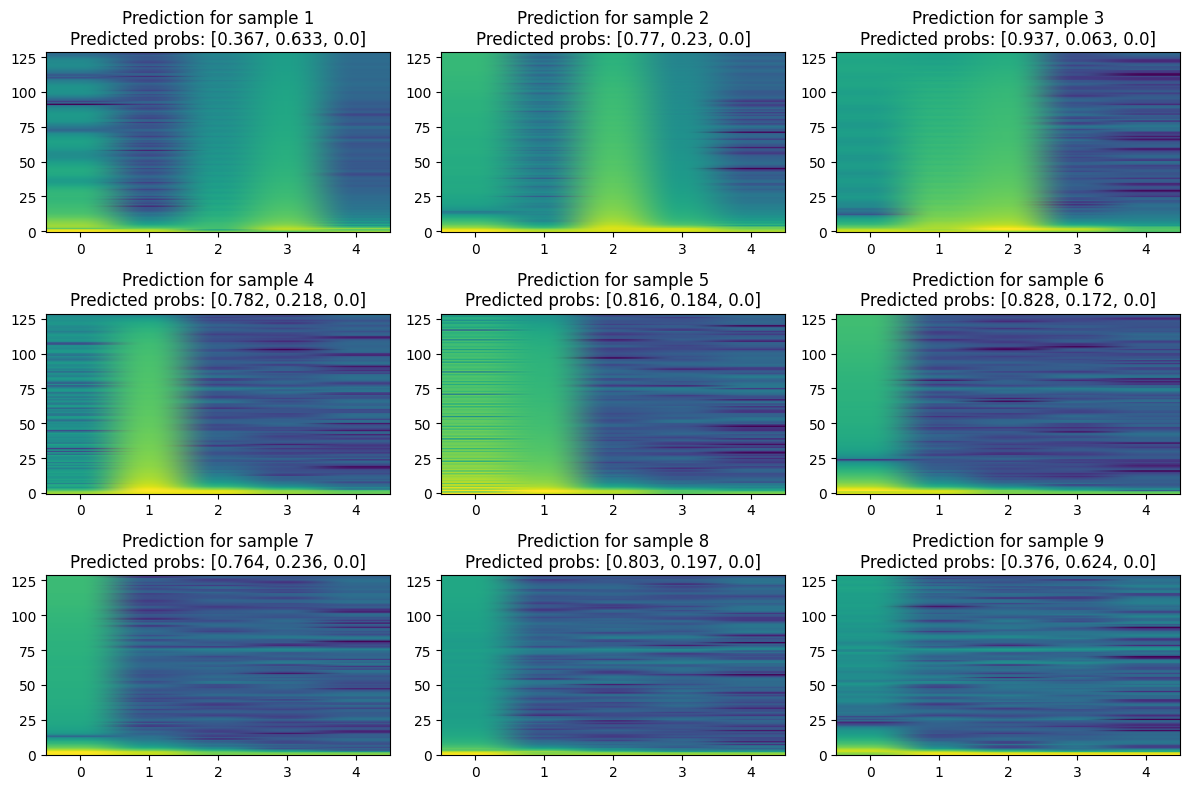

In [ ]:
# plot prediction of first 9 examples

fig, axs = plt.subplots(3, 3, figsize=(12, 8))
with torch.no_grad():
    model.eval()
    for audio in test_dataset:
        audio = audio.to(device)
        outputs = model(audio).cpu().numpy()
        for i in range(min(9, outputs.shape[0])):
            ax = axs[i // 3, i % 3]
            ax.imshow(audio[i].cpu().numpy()[0], aspect='auto', origin='lower')
            probs = outputs[i]
            probs = softmax(probs)
            probs = [round(p, 3) for p in probs]
            ax.set_title(f'Prediction for sample {i+1}\nPredicted probs: {probs}')
        break  # only process first batch
plt.tight_layout()
plt.show()

In [50]:
import soundfile as sf
sf.info(args.data.test_dataset.file_path)
waveform, sr = sf.read(args.data.test_dataset.file_path)
len(waveform) / sr

839.979

In [51]:
len(test_dataset)

23

In [52]:
# get predictions for all spectrograms in the dataset
all_predictions = []
with torch.no_grad():
    model.eval()
    for audio in tqdm(test_dataset):
        audio = audio.to(device)
        outputs = model(audio).cpu().numpy()
        probs = softmax(outputs, axis=1)
        all_predictions.append(probs)
all_predictions = np.vstack(all_predictions)
all_predictions.shape

100%|██████████| 23/23 [00:14<00:00,  1.55it/s]


(1464, 3)

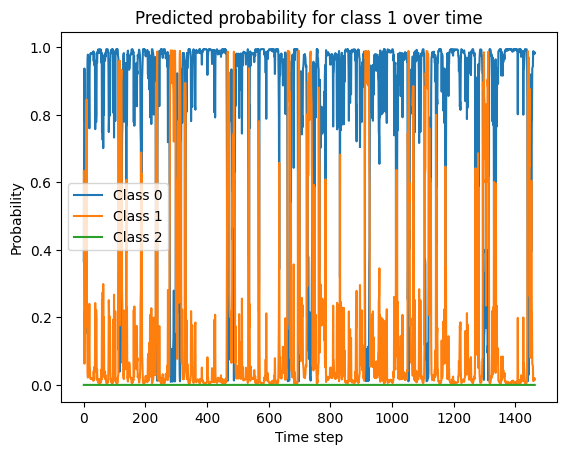

In [53]:
plt.plot(all_predictions[:])
plt.legend([f'Class {i}' for i in range(all_predictions.shape[1])])
plt.title('Predicted probability for class 1 over time')
plt.xlabel('Time step')
plt.ylabel('Probability')
plt.show()

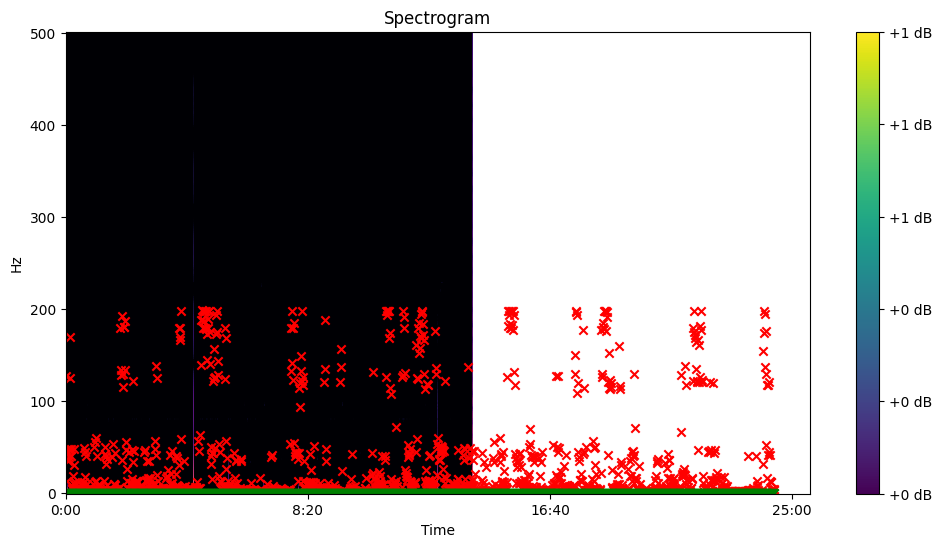

In [54]:
# use librosa to plot spectrogram
import librosa
import librosa.display
import matplotlib.pyplot as plt


spec = librosa.stft(waveform, n_fft=512, hop_length=256)
spec_db = librosa.amplitude_to_db(np.abs(spec), ref=np.max)
plt.figure(figsize=(12, 6))
librosa.display.specshow(spec_db, sr=sr, hop_length=256, x_axis='time', y_axis='hz')
plt.scatter(np.arange(all_predictions.shape[0]), all_predictions[:, 1] * 200, color='red', marker='x', label='Predictions')
plt.scatter(np.arange(all_predictions.shape[0]), all_predictions[:, 2] * 200, color='green', marker='x', label='Predictions')

plt.colorbar(format='%+2.0f dB')
plt.title('Spectrogram')
plt.show()

In [63]:
def get_start_end_times(preds, seq_length, overlap, threshold=0.98):
    times = []
    start_time = 0.0
    end_time = 0.0
    prev_val = False
    for i in range(len(preds)):
        curr = preds[i] >= threshold
        if curr and not prev_val:
            start_time = i * seq_length * (1 - overlap)
        if not curr and prev_val:
            end_time = (i-1) * seq_length * (1 - overlap)
            times.append({'start_time': start_time, 'end_time': end_time, 'duration': end_time - start_time, 'prob': preds[i-1]})
        prev_val = curr
    if prev_val:
        end_time = (len(preds) - 1) * seq_length * (1 - overlap)
        times.append({'start_time': start_time, 'end_time': end_time, 'duration': end_time - start_time})
    return times

def get_predictions(preds, seq_length, overlap, threshold=0.98, min_time=5.0):
    preds = get_start_end_times(preds, seq_length, overlap, threshold)
    filtered_preds = []
    for v in preds:
        if v['duration'] >= min_time:
            filtered_preds.append(v)
    return filtered_preds

# get predictions for class 1
preds_class_1 = all_predictions[:, 1]
predictions = get_predictions(preds_class_1, 
                              seq_length=dataset_args['seq_length'],
                              overlap=dataset_args['overlap'],
                              threshold=0.5,
                              min_time=3.0)


# get predictions for class 2
preds_class_2 = all_predictions[:, 2]
predictions_class_2 = get_predictions(preds_class_2, 
                              seq_length=dataset_args['seq_length'],
                              overlap=dataset_args['overlap'],
                              threshold=0.5,
                              min_time=5.0)
# predictions_class_2
predictions

[{'start_time': 159.42857142857136,
  'end_time': 170.28571428571422,
  'duration': 10.857142857142861,
  'prob': 0.69841355},
 {'start_time': 265.7142857142856,
  'end_time': 269.142857142857,
  'duration': 3.428571428571388,
  'prob': 0.92495495},
 {'start_time': 276.57142857142844,
  'end_time': 279.9999999999999,
  'duration': 3.428571428571445,
  'prob': 0.58571345},
 {'start_time': 377.71428571428555,
  'end_time': 382.85714285714266,
  'duration': 5.14285714285711,
  'prob': 0.567607},
 {'start_time': 414.85714285714266,
  'end_time': 423.4285714285712,
  'duration': 8.571428571428555,
  'prob': 0.56495917},
 {'start_time': 521.1428571428569,
  'end_time': 529.7142857142854,
  'duration': 8.571428571428555,
  'prob': 0.5873455},
 {'start_time': 600.5714285714283,
  'end_time': 603.9999999999998,
  'duration': 3.428571428571445,
  'prob': 0.59642273},
 {'start_time': 631.9999999999998,
  'end_time': 639.4285714285711,
  'duration': 7.428571428571331,
  'prob': 0.60451305},
 {'sta

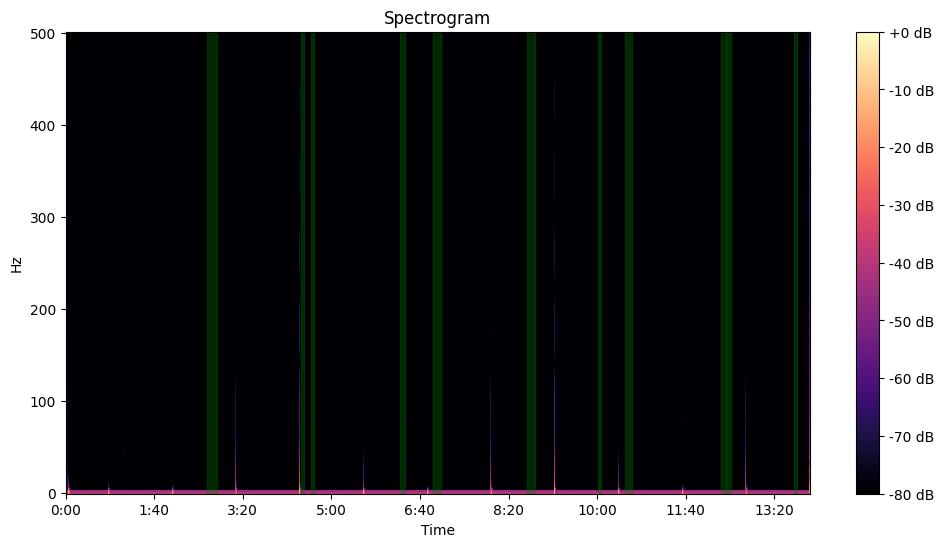

In [65]:
spec = librosa.stft(waveform, n_fft=512, hop_length=256)
spec_db = librosa.amplitude_to_db(np.abs(spec), ref=np.max)
plt.figure(figsize=(12, 6))
librosa.display.specshow(spec_db, sr=sr, hop_length=256, x_axis='time', y_axis='hz')

for v in predictions:
    plt.axvspan(v['start_time'], v['end_time'], color='green', alpha=0.3)
    
for v in predictions_class_2:
    plt.axvspan(v['start_time'], v['end_time'], color='red', alpha=0.3)


plt.colorbar(format='%+2.0f dB')
plt.title('Spectrogram')
plt.show()

In [59]:
# use fft to find frequancy boundrs:
predictions_class_2[0]
segment = waveform[int(predictions_class_2[0]['start_time'] * sr): int(predictions_class_2[0]['end_time'] * sr)]
fft_spectrum = np.fft.fft(segment)
freq = np.fft.fftfreq(len(fft_spectrum), 1/sr)
magnitude = np.abs(fft_spectrum)

# remove frequancies lower than 1 Hz
valid_indices = freq >= 4
freq = freq[valid_indices]
magnitude = magnitude[valid_indices]

# smooth magnitude using moving average with window size 5
window_size = 10
magnitude = np.convolve(magnitude, np.ones(window_size)/window_size, mode='same')

# plot frequency spectrum
plt.figure(figsize=(12, 6))
plt.plot(freq[:len(freq)//2], magnitude[:len(magnitude)//2])
# add hline at 50 percentile of max magnitude
plt.axhline(y=np.percentile(magnitude, 99), color='r', linestyle='--', label='50 percentile of max magnitude')
plt.legend()
plt.title('Frequency Spectrum of Detected Segment')
plt.xlabel('Frequency (Hz)')
plt.ylabel('Magnitude')
plt.xlim(0, 100)  # Focus on lower frequencies
plt.grid()
plt.show()

IndexError: list index out of range

In [ ]:
# find minimum and maximum frequency where magnitude is above 70 percent of max magnitude
threshold_magnitude = np.percentile(magnitude, 99.95)
min_freq = None
max_freq = None
bigger_than_threshold = 0
is_prev_max = False
for f, mag in zip(freq, magnitude):
    if mag >= threshold_magnitude:
        if min_freq is None:
            min_freq = f
        if is_prev_max:
            max_freq = f
            bigger_than_threshold += 1
        elif bigger_than_threshold < 2:
            max_freq = f
            bigger_than_threshold += 1
        else:
            continue
        
min_freq, max_freq

(25.272727272727273, 25.363636363636363)

In [ ]:
# def get_frequency_bounds(segment, sr, percentile=99.95, min_freq_threshold=4):
#     fft_spectrum = np.fft.fft(segment)
#     freq = np.fft.fftfreq(len(fft_spectrum), 1/sr)
#     magnitude = np.abs(fft_spectrum)

#     # remove frequancies lower than min_freq_threshold Hz
#     valid_indices = freq >= min_freq_threshold
#     freq = freq[valid_indices]
#     magnitude = magnitude[valid_indices]

#     # find minimum and maximum frequency where magnitude is above percentile of max magnitude
#     threshold_magnitude = np.percentile(magnitude, percentile)
#     min_freq = None
#     max_freq = None
#     for f, mag in zip(freq, magnitude):
#         if mag >= threshold_magnitude:
#             if min_freq is None:
#                 min_freq = f
#             max_freq = f
#     return min_freq, max_freq

In [ ]:
# try doing statistics on the stft of the call:
idx = 16
segment = waveform[int(predictions_class_2[idx]['start_time'] * sr): int(predictions_class_2[idx]['end_time'] * sr)]

spec = librosa.stft(segment, n_fft=512, hop_length=256)
# spec_db = librosa.amplitude_to_db(np.abs(spec), ref=np.max)
spec_db = np.abs(spec)

freqs = librosa.fft_frequencies(sr=sr, n_fft=512)
spec_db = spec_db[(freqs >= 4), :]
freqs = freqs[(freqs >= 4)]

mean_spec_db = np.mean(spec_db, axis=1)
plt.figure(figsize=(12, 6))
plt.scatter(freqs, mean_spec_db)
plt.axhline(y=np.percentile(mean_spec_db, 98), color='r', linestyle='--', label='99 percentile of mean dB')
plt.scatter(freqs[mean_spec_db >= np.percentile(mean_spec_db, 98)], 
            mean_spec_db[mean_spec_db >= np.percentile(mean_spec_db, 98)], 
            color='orange', label='Frequencies above 99 percentile')
plt.title('Histogram of Mean Spectrogram Values Across Time')
plt.xlabel('Frequency')
plt.ylabel('Mean dB')
plt.show()

IndexError: list index out of range

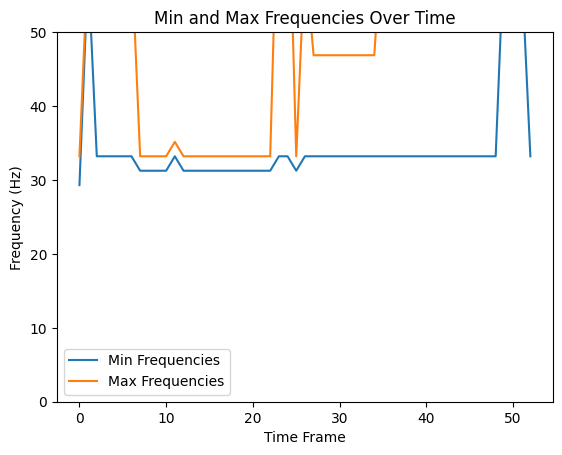

In [ ]:
idx = 3
segment = waveform[int(predictions_class_2[idx]['start_time'] * sr): int(predictions_class_2[idx]['end_time'] * sr)]

mins_freq, maxs_freq = [], []

spec = librosa.stft(segment, n_fft=512, hop_length=256)
# spec_db = librosa.amplitude_to_db(np.abs(spec), ref=np.max)
spec_db = np.abs(spec)

freqs = librosa.fft_frequencies(sr=sr, n_fft=512)
spec_db = spec_db[(freqs >= 10), :]
freqs = freqs[(freqs >= 10)]

# every 3 times steps, calculate mean value and then find min and max frequency above 99 percentile
step = 10
for t in range(step-1, spec_db.shape[1]-(step-1)):
    spec_slice = np.mean(spec_db[:, t-(step-1):t+step], axis=1)
    threshold = np.percentile(spec_slice, 99.5)
    above_threshold_indices = np.where(spec_slice >= threshold)[0]
    # print(above_threshold_indices)
    if len(above_threshold_indices) > 0:
        min_freq = freqs[above_threshold_indices[0]]
        max_freq = freqs[above_threshold_indices[-1]]
        mins_freq.append(min_freq)
        maxs_freq.append(max_freq)

plt.plot(mins_freq, label='Min Frequencies')
plt.plot(maxs_freq, label='Max Frequencies')
plt.title('Min and Max Frequencies Over Time')
plt.xlabel('Time Frame')
plt.ylim(0, 50)
plt.ylabel('Frequency (Hz)')
plt.legend()
plt.show()

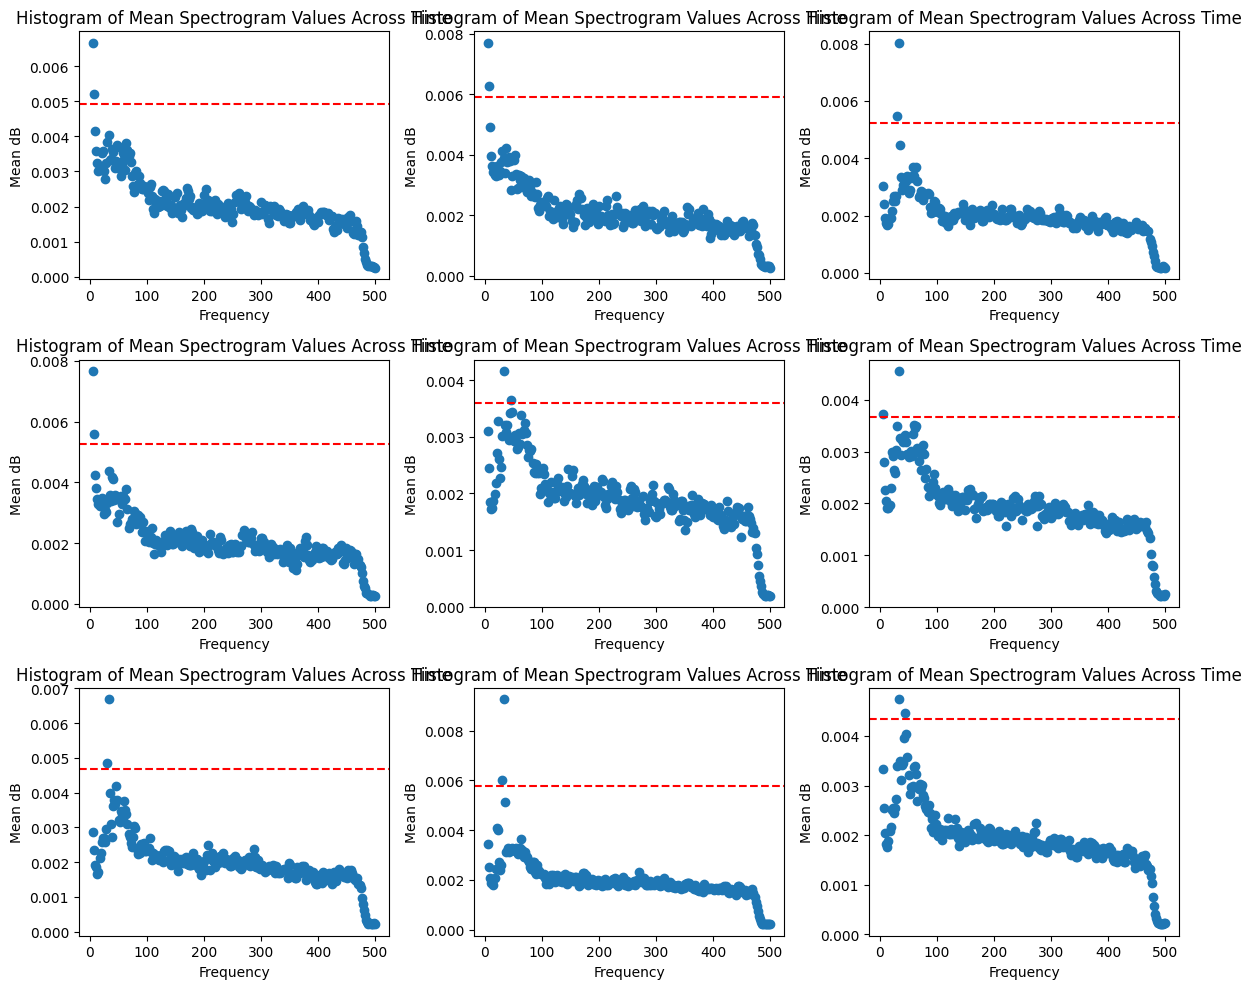

In [ ]:
figure, axs = plt.subplots(3, 3, figsize=(12, 10))

for i in range(9):
    ax = axs[i // 3, i % 3]
    segment = waveform[int(predictions_class_2[i]['start_time'] * sr): int(predictions_class_2[i]['end_time'] * sr)]


    spec = librosa.stft(segment, n_fft=512, hop_length=256)
    # spec_db = librosa.amplitude_to_db(np.abs(spec), ref=np.max)
    spec_db = np.abs(spec)

    freqs = librosa.fft_frequencies(sr=sr, n_fft=512)
    spec_db = spec_db[freqs >= 4, :]
    freqs = freqs[freqs >= 4]

    mean_spec_db = np.mean(spec_db, axis=1)
    ax.scatter(freqs, mean_spec_db)
    ax.axhline(y=np.percentile(mean_spec_db, 99.5), color='r', linestyle='--', label='95 percentile of mean dB')
    ax.set_title('Histogram of Mean Spectrogram Values Across Time')
    ax.set_xlabel('Frequency')
    ax.set_ylabel('Mean dB')
plt.tight_layout()
plt.show()

In [60]:
def get_frequency_boundaries(segment, sr, percentile=95, min_freq_threshold=4, max_freq_threshold=None):
    spec = librosa.stft(segment, n_fft=512, hop_length=256)
    # spec_db = librosa.amplitude_to_db(np.abs(spec), ref=np.max)
    spec_db = np.abs(spec)

    # remove time frames with abnormally high broadband power
    time_power = np.sum(spec_db ** 2, axis=0)
    q1, q3 = np.percentile(time_power, [25, 75])
    iqr = q3 - q1
    if iqr == 0:
        upper_thresh = time_power.mean() + 3 * time_power.std()
    else:
        upper_thresh = q3 + 3 * iqr
    keep_mask = time_power <= upper_thresh
    print(f'Removed {np.sum(~keep_mask)} out of {len(keep_mask)} time frames due to high broadband power.')
    if not np.any(keep_mask):  # fallback: keep all if everything is flagged
        keep_mask = np.ones_like(time_power, dtype=bool)
    spec_db = spec_db[:, keep_mask]

    freqs = librosa.fft_frequencies(sr=sr, n_fft=512)
    freqs_diff = freqs[1] - freqs[0]
    spec_db = spec_db[freqs >= min_freq_threshold, :]
    freqs = freqs[freqs >= min_freq_threshold]
    if max_freq_threshold is not None:
        spec_db = spec_db[freqs <= max_freq_threshold, :]
        freqs = freqs[freqs <= max_freq_threshold]

    mean_spec_db = np.mean(spec_db, axis=1)
    
    threshold_db = np.percentile(mean_spec_db, percentile)
    min_freq = None
    max_freq = None
    for f, db in zip(freqs, mean_spec_db):
        if db >= threshold_db:
            if min_freq is None:
                min_freq = f - freqs_diff / 2
            max_freq = f + freqs_diff / 2
    return min_freq, max_freq

In [64]:
def convert_preds_to_raven_format(predictions, class_name, channel=1, min_time_sec = 2):
    raven_bboxes = {
        'Selection': [],
        'Begin Time (s)': [],
        'End Time (s)': [],
        'Low Freq (Hz)': [],
        'High Freq (Hz)': [],
        'Channel': [],
        'Class Name': [],
        'Probability': []
    }
    cnt = 1
    for v in predictions:
        if (v['end_time'] - v['start_time']) < min_time_sec:
            continue
        segment = waveform[int(v['start_time'] * sr): int(v['end_time'] * sr)]
        low_freq, high_freq = get_frequency_boundaries(segment, sr, percentile=90, min_freq_threshold=15, max_freq_threshold=35)
        if high_freq > 50:
            continue  # skip this prediction if frequency band is too wide

        raven_bboxes['Selection'].append(int(cnt))
        cnt += 1
        raven_bboxes['Begin Time (s)'].append(v['start_time'])
        raven_bboxes['End Time (s)'].append(v['end_time'])

        # calculate frequency bounds
        
        if low_freq is not None and high_freq is not None:
            raven_bboxes['Low Freq (Hz)'].append(round(low_freq, 2))
            raven_bboxes['High Freq (Hz)'].append(round(high_freq, 2))
        else:
            raven_bboxes['Low Freq (Hz)'].append(0)
            raven_bboxes['High Freq (Hz)'].append(100)
        raven_bboxes['Channel'].append(channel)
        raven_bboxes['Class Name'].append(class_name)
        raven_bboxes['Probability'].append(v.get('prob', 1.0))
    return raven_bboxes

raven_class_1 = convert_preds_to_raven_format(predictions, class_name=label_names[1], channel=1, min_time_sec=5)
raven_class_2 = convert_preds_to_raven_format(predictions_class_2, class_name=label_names[2], channel=1, min_time_sec=5)

raven_df = pd.DataFrame(raven_class_1)
raven_df2 = pd.DataFrame(raven_class_2)
# print(raven_df2)
raven_df = pd.concat([raven_df, raven_df2], ignore_index=True)
raven_df['Selection'] = raven_df['Selection'].astype(int)
raven_df['Channel'] = raven_df['Channel'].astype(int)
print(raven_df)
raven_df = raven_df.sort_values(by='Begin Time (s)').reset_index(drop=True)
# raven_df.Selection = np.arange(1, len(raven_df) + 1, dtype=int)
file_name = args.data.test_dataset.file_path.split('/')[-1].split('.')[0] + args.data.test_dataset.file_path.split('/')[-1].split('.')[1]
raven_df.to_csv(index=False, path_or_buf=f'./outputs/CNNRNN_{file_name}_predictions_raven.txt', sep='\t')
# raven_df.to_csv('./outputs/temp_predictions_raven.csv', index=False)

Removed 0 out of 43 time frames due to high broadband power.
Removed 1 out of 21 time frames due to high broadband power.
Removed 0 out of 34 time frames due to high broadband power.
Removed 0 out of 34 time frames due to high broadband power.
Removed 0 out of 30 time frames due to high broadband power.
Removed 0 out of 21 time frames due to high broadband power.
   Selection  Begin Time (s)  End Time (s)  Low Freq (Hz)  High Freq (Hz)  \
0          1      159.428571    170.285714          32.23           34.18   
1          2      377.714286    382.857143          32.23           34.18   
2          3      414.857143    423.428571          32.23           34.18   
3          4      521.142857    529.714286          32.23           34.18   
4          5      632.000000    639.428571          32.23           34.18   
5          6      740.000000    745.142857          32.23           34.18   

   Channel Class Name  Probability  
0        1   ANT_BLUE     0.698414  
1        1   ANT_BLU

/tmp/ipykernel_1784655/2424808696.py:45: FutureWarning: The behavior of DataFrame concatenation with empty or all-NA entries is deprecated. In a future version, this will no longer exclude empty or all-NA columns when determining the result dtypes. To retain the old behavior, exclude the relevant entries before the concat operation.
  raven_df = pd.concat([raven_df, raven_df2], ignore_index=True)
